In [1]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [46]:
import gc
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import norm, multivariate_normal
# import timedelta
from datetime import datetime, timedelta
import lightgbm as lgb

# vizualization
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
#cdf from conditional quantile regression
def cqr_cdf(row, cdf_keyword): 
    #prob = betas.loc[:,('probabilities')].values
    #print(row)
    prob = row.index.values
    quantiles = row.values
    #quantiles[quantiles < 0] = 0
    #quantiles[quantiles > 1] = 1
    quantiles_extended = np.concatenate([[0], sorted(quantiles), [1]])
    probabilities_extended = np.concatenate([[0],prob,[1]])
    if cdf_keyword == 'cdf':
        interpolation = interp1d(quantiles_extended, probabilities_extended, bounds_error=False, fill_value=(0, 1))
    elif cdf_keyword == 'inv_cdf':
        interpolation = interp1d(probabilities_extended, quantiles_extended, bounds_error=False, fill_value=(0, 1))
    return interpolation

In [91]:
input_dir = './data/quantile/'
output_test = pd.read_csv(input_dir+'./year_qs_test.csv', index_col=0)
# change all but last column names to float
output_test.columns = [float(x) if x != 'hour' else x for x in output_test.columns]
data_test = pd.read_csv('./data/extra_test.csv', index_col=0, parse_dates=['timestamp'])
y = data_test['net_target'].values
qts = np.concatenate([[0.001],np.arange(0.05,0.951,0.05),[0.999]])
features = ['Month', 'Hour', 'hour_x', 'hour_y', 'month_x', 'month_y',
'net_target-1', 'diffuse_solar_radiation+1', 'relative_humidity+1', 'drybulb_temp+1']
target = 'net_target'
output.head()

,0.001,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,...,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.999,hour
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-08-02 00:00:00,0.310360,0.357515,0.366269,0.370381,0.371512,0.374360,0.375974,0.377014,0.382050,0.380493,...,0.385405,0.389247,0.401400,0.414912,0.429971,0.435761,0.470169,0.505395,0.822760,0
2021-08-02 01:00:00,0.310360,0.368597,0.397004,0.409418,0.418076,0.431889,0.433194,0.437272,0.437601,0.440130,...,0.446105,0.446119,0.449251,0.452369,0.464968,0.477420,0.488795,0.541063,0.822760,1
2021-08-02 02:00:00,0.317762,0.363231,0.380728,0.391533,0.404270,0.412055,0.414292,0.416644,0.418006,0.416466,...,0.421653,0.420844,0.424533,0.426552,0.434780,0.440315,0.446545,0.508745,0.822760,2
2021-08-02 03:00:00,0.304413,0.368901,0.389296,0.403086,0.418316,0.434724,0.442899,0.447951,0.445827,0.448121,...,0.452089,0.458047,0.458616,0.463705,0.475469,0.482647,0.493737,0.556686,0.822469,3
2021-08-02 04:00:00,0.292494,0.349550,0.360152,0.363746,0.367033,0.372829,0.373457,0.379888,0.385569,0.388895,...,0.398318,0.401174,0.405351,0.407885,0.417186,0.417636,0.437458,0.503593,0.822760,4


In [50]:
# for each file in the folder models
# load the model
model_dir = './models/'
# names of the files
files = os.listdir(model_dir)
# sort filenames in mathematical order
files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
# load the lgb models in txt files
models = [lgb.Booster(model_file=model_dir+file) for file in files]

In [51]:
files

['lgb_0.001.txt',
 'lgb_0.1.txt',
 'lgb_0.2.txt',
 'lgb_0.3.txt',
 'lgb_0.4.txt',
 'lgb_0.5.txt',
 'lgb_0.05.txt',
 'lgb_0.6.txt',
 'lgb_0.7.txt',
 'lgb_0.8.txt',
 'lgb_0.9.txt',
 'lgb_0.15.txt',
 'lgb_0.25.txt',
 'lgb_0.35.txt',
 'lgb_0.45.txt',
 'lgb_0.55.txt',
 'lgb_0.65.txt',
 'lgb_0.75.txt',
 'lgb_0.85.txt',
 'lgb_0.95.txt',
 'lgb_0.999.txt']

In [148]:
def estimate_pdf(row):
    qts_temp = {}
    for i, qt in enumerate(qts):
        # load lgb model 
        model = models[i]
        # predict the quantile
        qts_temp['{}'.format(qt)] = model.predict(row[features].values.reshape(1,-1)).item(0)
        # 
    qts_temp = pd.Series(data = list(qts_temp.values()), index = qts.round(3))
    mu, std = norm.fit(qts_temp)
    pdf = norm(mu, std)
    return pdf, qts_temp

In [124]:
qts_res

0.001    0.246067
0.050    0.387738
0.100    0.400070
0.150    0.402994
0.200    0.407661
0.250    0.409170
0.300    0.366437
0.350    0.409809
0.400    0.413074
0.450    0.423337
0.500    0.444644
0.550    0.396532
0.600    0.403963
0.650    0.408853
0.700    0.409491
0.750    0.408947
0.800    0.410672
0.850    0.417516
0.900    0.425427
0.950    0.478876
0.999    0.794623
dtype: float64

In [127]:
qts_res.index

Float64Index([0.001,  0.05,   0.1,  0.15,   0.2,  0.25,   0.3,  0.35,   0.4,
               0.45,   0.5,  0.55,   0.6,  0.65,   0.7,  0.75,   0.8,  0.85,
                0.9,  0.95, 0.999],
             dtype='float64')

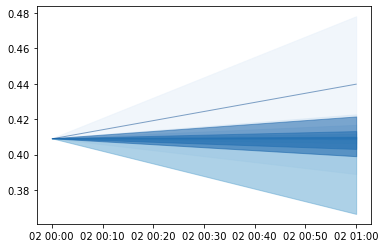

In [167]:
row = data_test.iloc[1]
pdf, qts_res = estimate_pdf(row)
dates = np.array([(row.timestamp - timedelta(hours=1)), row.timestamp])
init_v = row['net_target-1']
# make a list with a gradient of 10 colours from light blue to dark blue
colors = sns.color_palette("Blues", 10)
# plt the confidence intervals between 0.05 and 0.95
plt.fill_between(dates, np.array([init_v, qts_res[0.05]]), np.array([init_v, qts_res[0.95]]), alpha=0.5, color=colors[0])
plt.fill_between(dates, np.array([init_v, qts_res[0.1]]), np.array([init_v, qts_res[0.9]]), alpha=0.5, color=colors[1])
plt.fill_between(dates, np.array([init_v, qts_res[0.15]]), np.array([init_v, qts_res[0.85]]), alpha=0.5, color=colors[2])
plt.fill_between(dates, np.array([init_v, qts_res[0.2]]), np.array([init_v, qts_res[0.8]]), alpha=0.5, color=colors[3])
plt.fill_between(dates, np.array([init_v, qts_res[0.25]]), np.array([init_v, qts_res[0.75]]), alpha=0.5, color=colors[4])
plt.fill_between(dates, np.array([init_v, qts_res[0.3]]), np.array([init_v, qts_res[0.7]]), alpha=0.5, color=colors[5])
plt.fill_between(dates, np.array([init_v, qts_res[0.35]]), np.array([init_v, qts_res[0.65]]), alpha=0.5, color=colors[6])
plt.fill_between(dates, np.array([init_v, qts_res[0.4]]), np.array([init_v, qts_res[0.6]]), alpha=0.5, color=colors[7])
plt.fill_between(dates, np.array([init_v, qts_res[0.45]]), np.array([init_v, qts_res[0.55]]), alpha=0.5, color=colors[8])
plt.fill_between(dates, np.array([init_v, qts_res[0.5]]), np.array([init_v, qts_res[0.5]]), alpha=0.5, color=colors[9])

# plot the net_target-1 and the datetimeindex minus one hour
#plt.plot((data_test.iloc[0].timestamp - timedelta(hours=1)), data_test.iloc[0]['net_target-1'])


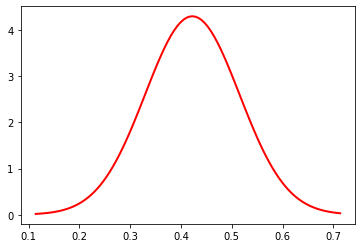

In [161]:
# Generate a range of x values for the plot
x = np.linspace(mu - 3*std, mu + 3*std, 100)

# Evaluate the PDF at each x value
y = pdf.pdf(x)

# Plot the PDF
plt.plot(x, y, 'r-', lw=2)
plt.show()


In [165]:
pdf.rvs(size=5)

array([0.5238338 , 0.46979936, 0.68254008, 0.30419601, 0.4755641 ])

In [21]:
cdf = cqr_cdf(output.iloc[0,:-1], 'cdf')
x = np.linspace(-1,1,100)
pdf = np.gradient(cdf(x), x)

In [22]:
pdf

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.05514988e-04, 2.41654496e-03, 3.22205995e-03,
       3.22205995e-03, 3.22205995e-03, 3.22205995e-03, 3.22205995e-03,
      

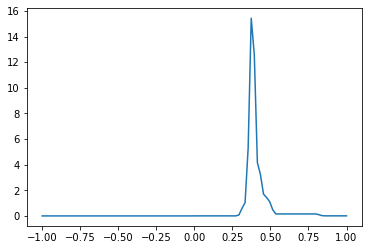

In [24]:
plt.plot(np.linspace(-1,1,100), pdf)

In [ ]:
class expando:
    pass 

class modelEstimation:
    def __init__(self, qs, data): 
        print('modelEstimation class initialized')
        print('Cooking up the cdf distributions')
        self._set_cdf(qs)
    def _set_cdf(self, data):
        self.cdf = expando()
        self.inv_cdf = expando()
        for leadT in data.hour.unique():
            cdf_loc_leadT = \
                lambda prediction, cdf_keyword='cdf': \
                cqr_cdf(prediction, cdf_keyword)
            setattr(self.cdf, str(leadT), cdf_loc_leadT)

            inv_cdf_loc_leadT = \
                lambda prediction, cdf_keyword='inv_cdf': \
                cqr_cdf(prediction, cdf_keyword)
            setattr(self.inv_cdf, str(leadT), inv_cdf_loc_leadT)
        pass
